# Run these cells for both GAN and Classifier

In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kepler-labelled-time-series-data/exoTest.csv
/kaggle/input/kepler-labelled-time-series-data/exoTrain.csv


In [60]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

np.random.seed(1)

print('Loading train and test data...')
df=pd.read_csv('../input/kepler-labelled-time-series-data/exoTrain.csv')
#print(df1)
df2=pd.read_csv('../input/kepler-labelled-time-series-data/exoTest.csv')
#print(df2)

Loading train and test data...


In [61]:
#print(train_data)
test_data=np.array(df2,dtype=np.float32)
#print(test_data)


Y=df.loc[:,df.columns=="LABEL"]
X=df.loc[:,df.columns!="LABEL"]
ytest=test_data[:,0]
Xtest=test_data[:,1:]
# print(ytrain,'\n',Xtrain)
# print(ytest,'\n',Xtest)

m=1 # A chosen exoplanet host star's index for plott
n=100 # A chosen non-exoplanet host star's index

#print('Shape of Xtrain:',np.shape(Xtrain),'\nShape of ytrain:',np.shape(ytrain))

Xtrain =X
Y =Y.to_numpy()

# plt.plot(X.iloc[m],'r')
# plt.title('Light intensity vs time (for an exoplanet star)')
# plt.xlabel('Time index')
# plt.ylabel('Light intensity')
# plt.show()

Applying Fourier Transform...


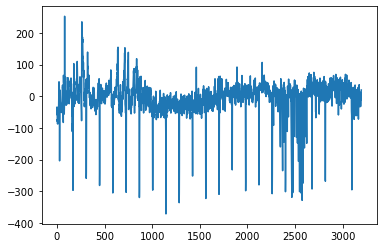

In [55]:
from scipy.fftpack import fft,ifft

print('Applying Fourier Transform...')

Xtrain=Xtrain.to_numpy()
plt.figure(5)
plt.plot(Xtrain[1])
Xtrain=Xtrain[:,:1+int((len(Xtrain[0])-1)/2)]






# GAN MODEL ONLY, Run Cells below to train GAN generate transit Light Curves

In [56]:
print(Xtrain.shape)
print(Y.shape)
Xtrain = np.reshape(Xtrain,(Xtrain.shape[0],1,Xtrain.shape[1]))
print(Xtrain.shape)
print(Y)

for i in range(len(Y)):
    if Y[i]==1:
        Y[i]=0
for i in range(len(Y)):
    if Y[i]==2:
        Y[i]=1
print(Y)


(5087, 1599)
(5087, 1)
(5087, 1599, 1)
[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]]
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [57]:
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.layers import LSTM,SimpleRNN
from keras.layers import Dropout,GRU,Flatten,Input
from keras.layers import TimeDistributed,Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from keras.optimizers import Adam,Adamax,Nadam
adam = Adam(learning_rate = 3E-2)

In [ ]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=512,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=Xtrain.shape[2]))
    
    generator.add(Reshape((1,Xtrain.shape[2])))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam)
    return generator
g = create_generator()
g.summary()


def create_discriminator():
    model = Sequential()
    model.add(LSTM(units =256,input_shape=(1,Xtrain.shape[2]),return_sequences = True))
    model.add(Dropout(0.3))
    model.add(LSTM(units =256,return_sequences = True))
    model.add(Dropout(0.3))
    model.add(LSTM(units =128,return_sequences = False))
    model.add(Dropout(0.3))
    model.add(Dense(units =1,activation = "sigmoid"))
    model.compile(loss='binary_crossentropy',optimizer="rmsprop",metrics = ["accuracy"])
    return model
d =create_discriminator()
d.summary()

def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)

    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return gan

gan = create_gan(d,g)
gan.summary()




def training(epochs=1, batch_size=128):
    
    #Loading the data
    X_train, y_train = Xtrain,Y
    batch_count = X_train.shape[0] / batch_size
    X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            X = np.reshape(X,(X.shape[0],X.shape[1],1))
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 25 == 0:
            print(generated_images.shape)
        
            for i in range(0,batch_size):
                plt.figure()
                plt.plot(generated_images[i])
            plt.show()
        if e==epochs:
            for i in range(0,batch_size,2):
                plt.figure()
                plt.plot(generated_images[i])
            generator.save("generator_trial2.h5")
            generator.save_weights("generator_weights2.h5")
            gan.save("gan_trial2")
            discriminator.save("discriminator_trial2.h5")
training(250,10)
    

EXPORT THE MODEL

In [ ]:
model = load_model("gan_trial2")
print(model.summary())

In [ ]:

new_model = Model(model.get_layer("sequential_2").input,model.get_layer("sequential_2").output)
new_model.load_weights("generator_weights2.h5")

print(new_model.summary())

#model.compile(loss='binary_crossentropy', optimizer=adam)

batch_size = 5
noise = np.random.normal(0,1,[batch_size,100])
test = new_model.predict(noise)
def printer():
    for i in range(0,batch_size):
        plt.figure()
        plt.plot(test[i])
    plt.show()
printer()

# CLASSIFIER MODEL, Run cells below to train the LSTM and make predictions

Data Preprocessing

Applying Fourier Transform...
[[ 31822.48         3542.69725989  55671.61280692 ...  52952.70195631
   55671.61280692   3542.69725989]
 [ 23747.1         18904.03483095  23034.01375377 ...  23943.70167127
   23034.01375377  18904.03483095]
 [ 26180.51       143610.48759074  41912.29468855 ... 365999.61678651
   41912.29468855 143610.48759074]
 ...
 [  9398.42000001   5514.03371502  18216.47890902 ...   7032.65269996
   18216.47890902   5514.03371502]
 [  2567.54         1986.45522747   2780.97513937 ...   3810.82651497
    2780.97513937   1986.45522747]
 [ 16608.95000001  12716.78586068  20542.92617575 ...   8212.03658663
   20542.92617575  12716.78586068]] (5087, 3197)


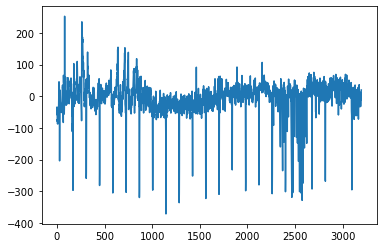

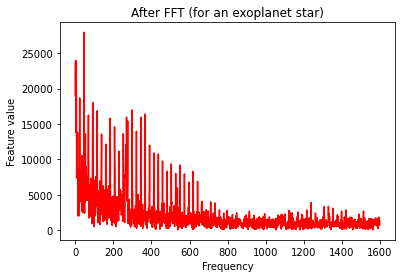

Normalizing...


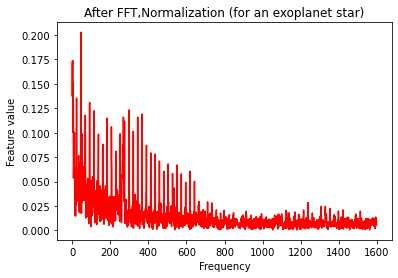

Applying Gaussian filter...


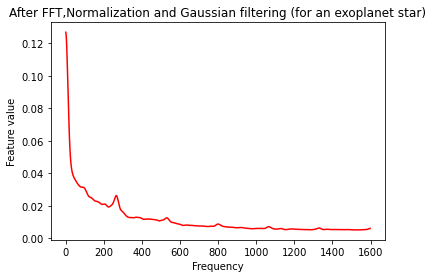

Applying MinMaxScaler...


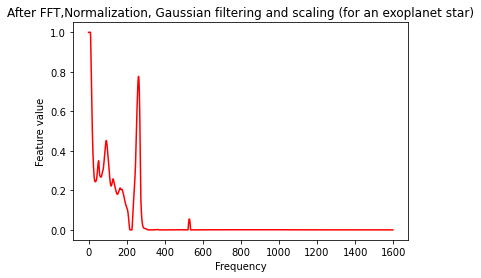

In [62]:
from scipy.fftpack import fft,ifft

print('Applying Fourier Transform...')

Xtrain=Xtrain.to_numpy()
plt.figure(5)
plt.plot(Xtrain[1])
Xtrain=np.abs(fft(Xtrain,n=len(Xtrain[m]),axis=1))


print(Xtrain,Xtrain.shape)

Xtrain=Xtrain[:,:1+int((len(Xtrain[0])-1)/2)]



Xtest=Xtest[:,:1+int((len(Xtest[0])-1)/2)]
plt.figure(1)
save_train_m = Xtrain[m]
plt.plot(Xtrain[m],'r')
plt.title('After FFT (for an exoplanet star)')
plt.xlabel('Frequency')
plt.ylabel('Feature value')
plt.show()

#### Normalizing

from sklearn.preprocessing import normalize

print('Normalizing...')
Xtrain=normalize(Xtrain)
Xtest=normalize(Xtest)
plt.figure(2)
plt.plot(Xtrain[m],'r')
plt.title('After FFT,Normalization (for an exoplanet star)')
plt.xlabel('Frequency')
plt.ylabel('Feature value')
plt.show()




#### Applying Gaussian Filter

from scipy import ndimage

print('Applying Gaussian filter...')
Xtrain=ndimage.filters.gaussian_filter(Xtrain,sigma=10)
Xtest=ndimage.filters.gaussian_filter(Xtest,sigma=10)
plt.figure(3)
plt.plot(Xtrain[m],'r')
plt.title('After FFT,Normalization and Gaussian filtering (for an exoplanet star)')
plt.xlabel('Frequency')
plt.ylabel('Feature value')
plt.show()




#### Scaling down the data

from sklearn.preprocessing import MinMaxScaler

print('Applying MinMaxScaler...')
scaler=MinMaxScaler(feature_range=(0,1))
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.fit_transform(Xtest)
plt.figure(4)
plt.plot(Xtrain[m],'r')
plt.title('After FFT,Normalization, Gaussian filtering and scaling (for an exoplanet star)')
plt.xlabel('Frequency')
plt.ylabel('Feature value')
plt.show()

In [63]:
print(Xtrain.shape)
print(Y.shape)
Xtrain = np.reshape(Xtrain,(Xtrain.shape[0],1,Xtrain.shape[1]))
print(Xtrain.shape)
print(Y)

for i in range(len(Y)):
    if Y[i]==1:
        Y[i]=0
for i in range(len(Y)):
    if Y[i]==2:
        Y[i]=1
print(Y)

(5087, 1599)
(5087, 1)
(5087, 1, 1599)
[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]]
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [64]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    Classifier = Sequential()
    Classifier.add(LSTM(units =256,input_shape=(1,Xtrain.shape[2]),return_sequences = True))
    Classifier.add(Dropout(0.3))
    Classifier.add(LSTM(units =256,return_sequences = True))
    Classifier.add(Dropout(0.3))
    Classifier.add(LSTM(units =128,return_sequences = False))
    Classifier.add(Dropout(0.3))
    Classifier.add(Dense(units =1,activation = "sigmoid"))
    Classifier.compile(loss='binary_crossentropy',optimizer="adam",metrics = ["accuracy"])

Classifier.fit(Xtrain,Y,epochs = 10)

Classifier.save("classifier_trial1.h5")

Epoch 1/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0434 - accuracy: 0.9915
Epoch 2/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0112 - accuracy: 0.9980
Epoch 3/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0102 - accuracy: 0.9982
Epoch 4/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0072 - accuracy: 0.9984
Epoch 5/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0074 - accuracy: 0.9988
Epoch 6/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0052 - accuracy: 0.9990
Epoch 7/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0086 - accuracy: 0.9986
Epoch 8/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0054 - accuracy: 0.9986
Epoch 9/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0018 - accuracy: 0.9994
Epoch 10/10
159/159 [==============================] - 2s 10ms/step - loss: 0.0053 - accura

In [65]:
print(Xtrain[1])
#plt.plot(Xtrain[34])
#plt.show()
print(Y[23])

[[9.99290895e-01 9.99314418e-01 9.99360692e-01 ... 1.93427434e-04
  1.89191340e-04 1.87030383e-04]]
[1]


In [66]:
print(Xtrain[0].shape)

y = Classifier.predict(Xtrain)


(1, 1599)


In [67]:
print(max(y))
print(y[322])
print(Y[322])

[0.99394095]
[8.0257654e-05]
[0]
